In [ ]:
!pip install opencv-python
!pip install pandas
!pip install matplotlib
!pip install gdown
!pip install sklearn
!pip install scipy
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import gdown as gdown
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms.transforms import Normalize

In [2]:
url =  'https://drive.google.com/uc?export=download&id=1UGNAWPEe2YtkZNx3chPJRNbJMyHXU3Z6'
output = 'A_Z Handwritten Data.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1UGNAWPEe2YtkZNx3chPJRNbJMyHXU3Z6
To: C:\Users\Jorge\AI\A_Z Handwritten Data.csv
100%|██████████| 699M/699M [00:50<00:00, 13.7MB/s] 


'A_Z Handwritten Data.csv'

In [2]:
PATH = os.getcwd()
data = pd.read_csv(PATH + "/A_Z Handwritten Data.csv", header=None).astype('float32').to_numpy()
# column 0 = label
print(data.shape)

(372451, 785)


In [3]:
np.random.shuffle(data)
x_data = data[:, 1:]
labels = data[:, 0]
y_data = []
for i in labels:
  labels_v = np.zeros(26, dtype=np.float32)
  labels_v[int(i)] = 1
  y_data.append(labels_v)
y_data = np.array(y_data)
normalizer = MinMaxScaler()
normalizer.fit(x_data)
print(x_data.shape)
print(y_data.shape)

(372451, 784)
(372451, 26)


14 12 15 10 21 15 17 20 3 20 

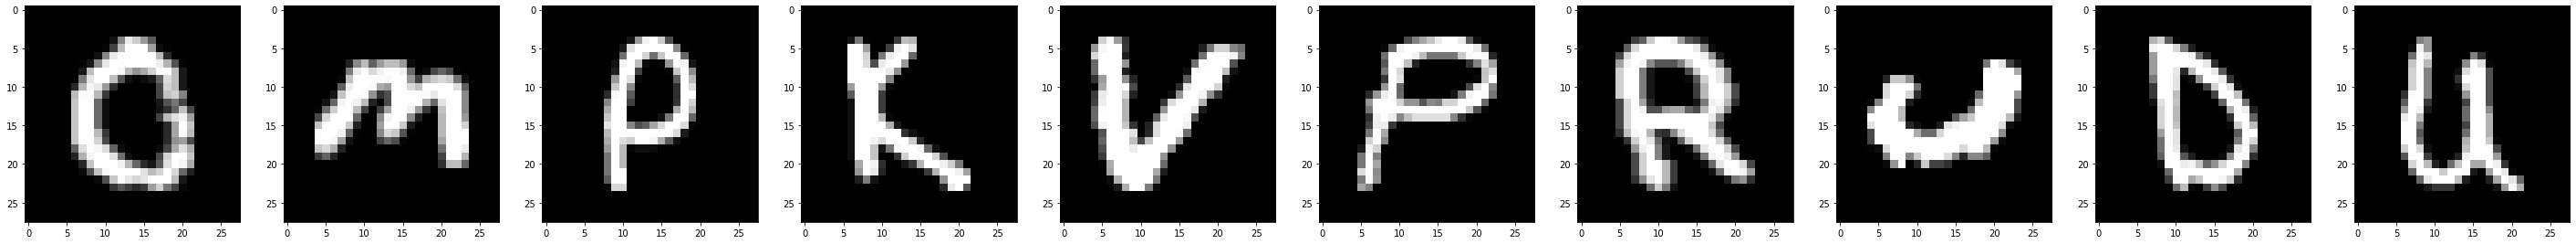

In [4]:
plt.figure(figsize = (50, 10))
r, c = 1, 10
for i in range(r * c):  
    plt.subplot(r, c, i+1)
    plt.imshow(x_data[i].reshape(28,28), cmap='gray')
    print(np.argmax(y_data[i]), end = " ")
plt.show()

In [5]:
transform = transforms.ToTensor()
data_set = []
for i in range(x_data.shape[0]):
  data_set.append(( transform(x_data[i].reshape(28, 28)), torch.tensor(y_data[i]) ))

In [6]:
n_train = int(0.8 * len(x_data))
n_validation = int(0.1 * len(x_data))
train_set = data_set[:n_train]
validation_set = data_set[n_train:n_train + n_validation]
test_set = data_set[n_train + n_validation:]

print("train set length:", len(train_set))
print("validation set length:", len(validation_set))
print("test set length:", len(test_set))
print("set type:", type(train_set))
print("data set type:", type(train_set[0]))
a, b = train_set[0] 
print("first data set type:", type(a))
print("first data shape:", a.shape)
print("second data set type:", type(b))
print("second data shape:", b.shape)

train set length: 297960
validation set length: 37245
test set length: 37246
set type: <class 'list'>
data set type: <class 'tuple'>
first data set type: <class 'torch.Tensor'>
first data shape: torch.Size([1, 28, 28])
second data set type: <class 'torch.Tensor'>
second data shape: torch.Size([26])


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

cuda:0


In [8]:
class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        '''self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6)
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16)
        )
        self.avgpool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)'''
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.avgpool1 = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.avgpool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(in_features=400, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=26)

    def forward(self, image):
        debug = 0
        if(debug):
            print("****************************************************************")
            print("image",image.shape)
        out = F.relu(self.conv1(image))
        if(debug):
            print("conv1",out.shape)
        out = self.avgpool1(out)
        if(debug):
            print("avgpool1",out.shape)
        out = F.relu(self.conv2(out))
        if(debug):
            print("convolucion2",out.shape)
        out = self.avgpool2(out)
        if(debug):
            print("avgpool2",out.shape)
        '''out = F.relu(self.layer1(image))
        out = self.avgpool1(out)
        out = F.relu(self.layer2(out))
        out = self.avgpool2(out)'''
        out = out.view(out.size(0), -1)
        if(debug):
            print("MLP",out.shape)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        z = F.softmax(out, dim = 1)
        if(debug):
            print("z", z.shape)
            print("z[0]", z[0])
            print("z[0] sum", z[0].sum())
            print("z[1] sum", z[1].sum())
        return z

In [9]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    validation_loss_avg = []
    
    for epoch in range(Epochs):
        model.train()

        train_loss_avg.append(0)
        num_batches = 0
        total = 0
        correct = 0

        for image_batch, label_batch in train_loader:
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            
            label_batch_pred = model(image_batch)
            loss = loss_fn(label_batch, label_batch_pred)

            _, test = torch.max(label_batch.data, 1)
            _, predicted = torch.max(label_batch_pred.data, 1)
            total += label_batch.size(0)
            correct += (predicted == test).sum().item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        train_accuracy = 100.0 * correct / total 

        validation_loss_avg.append(0)
        num_batches = 0
        total = 0
        correct = 0

        model.eval()

        with torch.no_grad():
            for image_batch, label_batch in test_loader:
                image_batch = image_batch.to(device)
                label_batch = label_batch.to(device)
            
                label_batch_pred = model(image_batch)
                loss = loss_fn(label_batch, label_batch_pred)

                _, test = torch.max(label_batch.data, 1)
                _, predicted = torch.max(label_batch_pred.data, 1)
                total += label_batch.size(0)
                correct += (predicted == test).sum().item()

                validation_loss_avg[-1] += loss.item()
                num_batches += 1

        validation_loss_avg[-1] /= num_batches
        validation_accuracy = 100.0 * correct / total

        print(f'Epoch [{epoch+1} / {Epochs}] training error: {train_loss_avg[-1]:.4f}, training accuracy: {train_accuracy:.4f}%, validation error: {validation_loss_avg[-1]:.4f}, validation accuracy: {validation_accuracy:.4f}%')
      
    return train_loss_avg, validation_loss_avg

In [ ]:
capacity = 64
learning_rate = 0.02

model = Lenet5()
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

training_loss, validation_loss = train(model,train_loader,10,loss)

Epoch [1 / 10] training error: 3.1924, training accuracy: 12.9736%, validation error: 3.1910, validation accuracy: 13.1101%
Epoch [2 / 10] training error: 3.1923, training accuracy: 12.9830%, validation error: 3.1910, validation accuracy: 13.1101%
Epoch [3 / 10] training error: 3.1923, training accuracy: 12.9789%, validation error: 3.1910, validation accuracy: 13.1101%


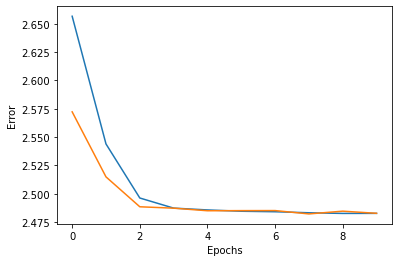

In [47]:
fig = plt.figure()
plt.plot(training_loss)
plt.plot(validation_loss)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [48]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for image_batch, label_batch in test_loader:
        image_batch = image_batch.to(device)
    
        label_batch_pred = model(image_batch)

        image_batch = image_batch.to('cpu')
        label_batch_pred = label_batch_pred.to('cpu')

        _, test = torch.max(label_batch.data, 1)
        _, predicted = torch.max(label_batch_pred.data, 1)
        total += label_batch.size(0)
        correct += (predicted == test).sum().item()
print(f'Total tested: {total}')
print(f'Correct tested: {correct}')
print(f'Accuracy: {100 * correct // total} %')

Total tested: 37246
Correct tested: 31261
Accuracy: 83 %
